In [1]:
import sys
import time
import logging
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import cmasher as cmr
from pathlib import Path

import astropy.units as u
from astropy.nddata import StdDevUncertainty
from astropy.modeling import models
from specutils import Spectrum1D

log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format='%(asctime)s %(levelname)s [%(name)s] %(message)s')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL').setLevel(logging.WARNING)

ROOT_DIR = Path('/Users/palmerio/Code_projects/astropalmerio/dev/')

plt.style.use('paper')
plt.style.use('kraken')

In [2]:

from astropalmerio.spectra.conversions import ergscm2AA
from astropalmerio.spectra.visualization import plot_spectrum, set_standard_spectral_labels
from astropalmerio.spectra.utils import gaussian_fct
from astropalmerio.spectra.emission_lines import EmissionLine

# Measuring emission lines from spectra
In this example, we will see how to leverage the capabilities of `specutils` and `astropy` to fit a simple Gaussian model to an H$\alpha$ emission line in a synthetic spectrum

### Create synthetic spectrum

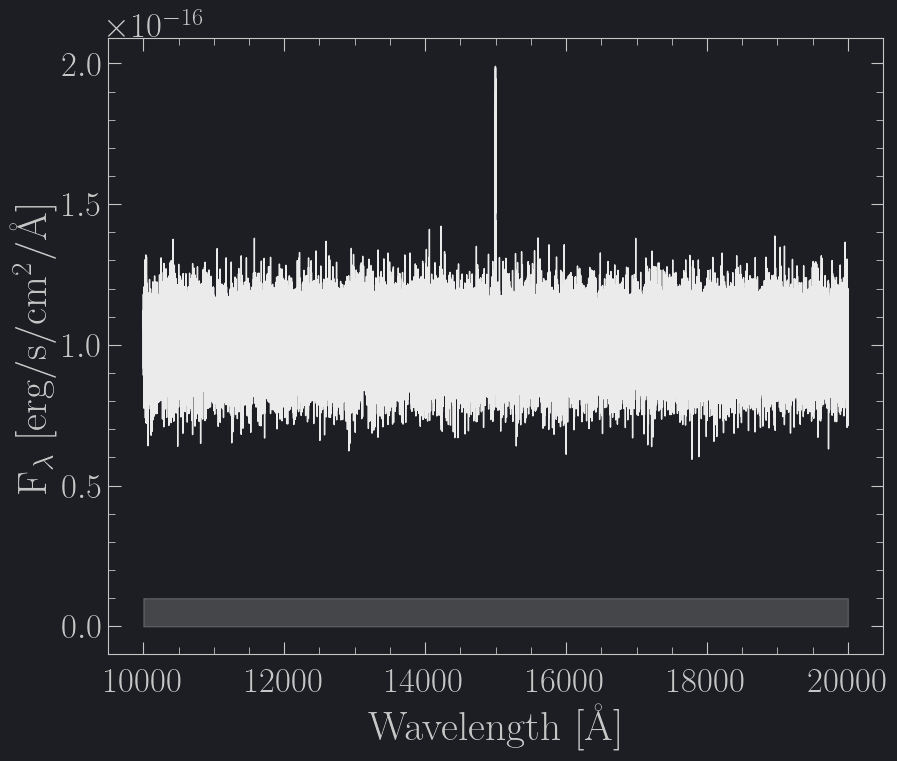

In [4]:
wave = np.arange(10000, 20000, 0.2) * u.AA
flux = (default_rng().standard_normal(len(wave)) + 10) * 1e-17 * ergscm2AA
error = 1e-17 * np.ones(len(flux)) * ergscm2AA
flux = flux + gaussian_fct(x=wave, mean=15000.0*u.AA, stddev=5.0*u.AA, amplitude=8e-17*ergscm2AA)
plot_spectrum(wave, flux, error, color='C12')
set_standard_spectral_labels()

## Create the EmissionLine object that will be used
We will provide the bounds to extract a region of the spectrum to work with.
Alternatively, we could provide a guess of the redshift of the source so that some automatic bounds can be used for the extraction.

2023-02-11 21:17:10,544 DEBUG [astropalmerio.spectra.emission_lines] Attempting to extract the following bounds: (14800.0 Angstrom, 15200.0 Angstrom)


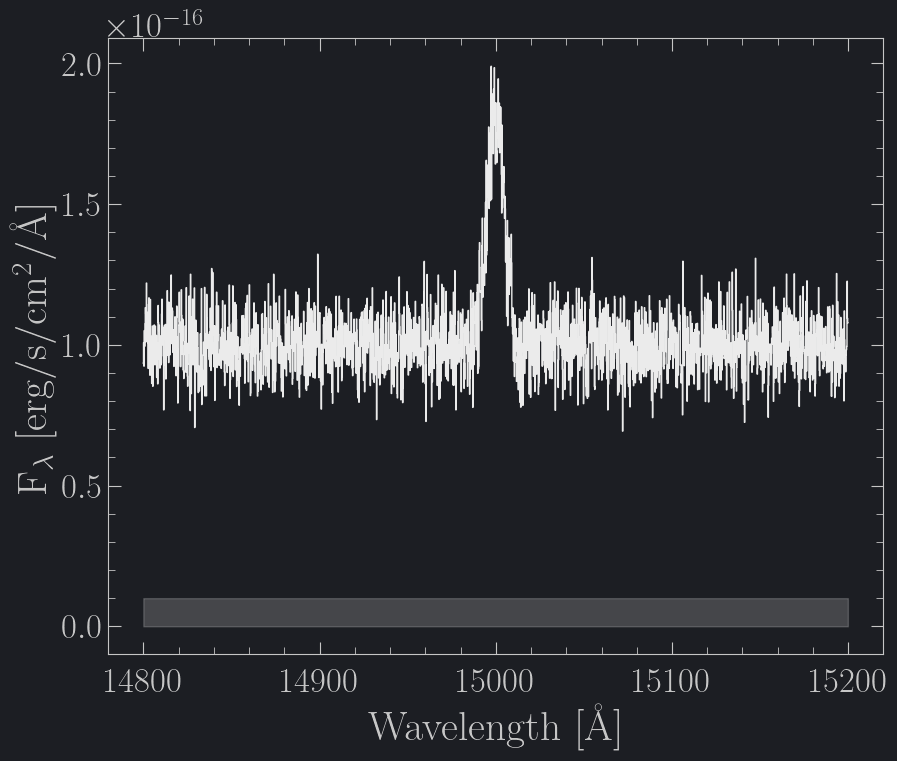

In [5]:
logging.getLogger('astropalmerio.spectra').setLevel(logging.DEBUG)

Ha = EmissionLine('H_alpha')
# If using a guess redshift to extract bounds
# Ha = EmissionLine('H_alpha', z_guess=1.29)

Ha.extract_line_region(
    spectrum=Spectrum1D(
        spectral_axis=wave,
        flux=flux,
        uncertainty=StdDevUncertainty(error)
    ),
    bounds=(14800*u.AA, 15200*u.AA)
)
Ha.show_spectrum(color='C12')
set_standard_spectral_labels()

2023-02-11 21:17:11,323 WARNING [astropy] Model is linear in parameters; consider using linear fitting methods.


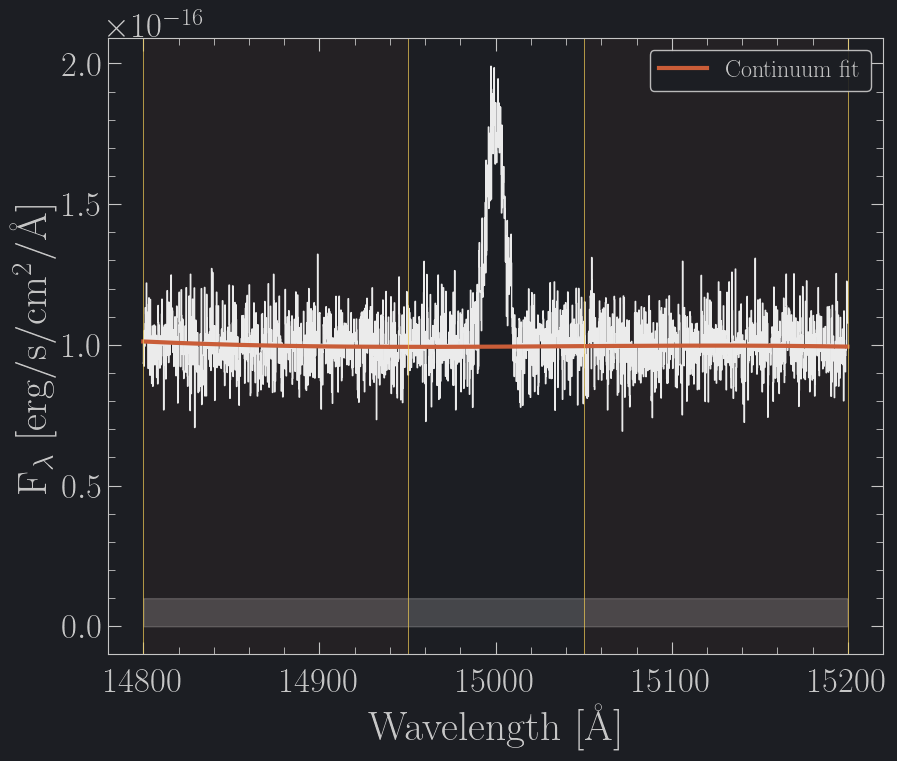

In [6]:
Ha.fit_continuum(
    regions=[
        (14800*u.AA,14950*u.AA,),
        (15050*u.AA,15200*u.AA,),
    ]
)
Ha.show_continuum(show_spec_kwargs={'color':'C12'})
plt.gca().legend()
set_standard_spectral_labels()

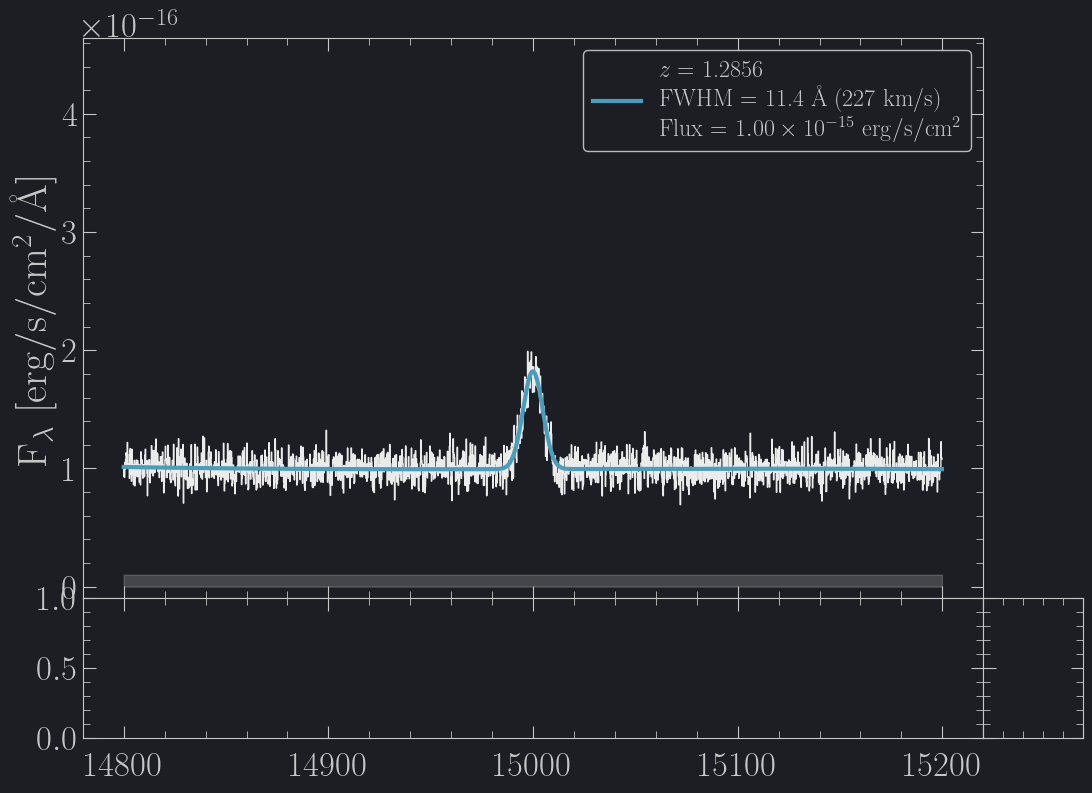

In [7]:
Ha.fit_single_gaussian()
Ha.show_fit(
    spec_plot_kw={'color':'C12'}
)
plt.gcf().axes[0].legend()
set_standard_spectral_labels(ax=plt.gcf().axes[0])

2023-02-12 13:32:47,181 WARNING [astropy] Model is linear in parameters; consider using linear fitting methods.


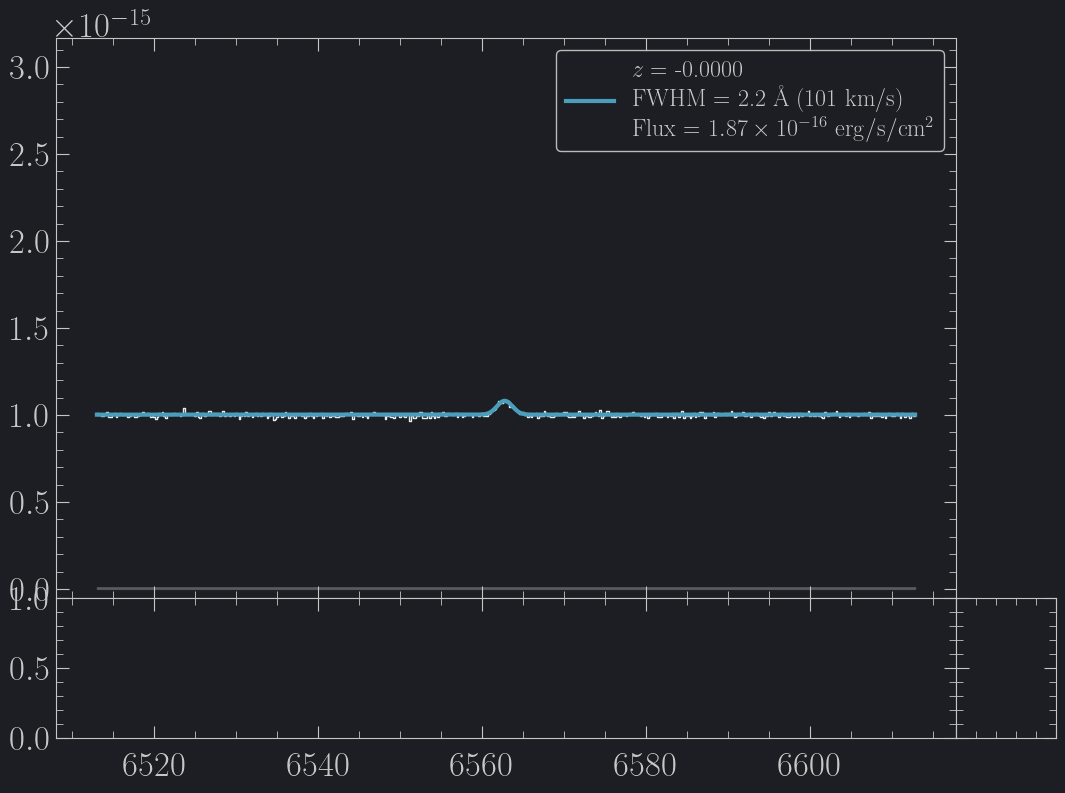

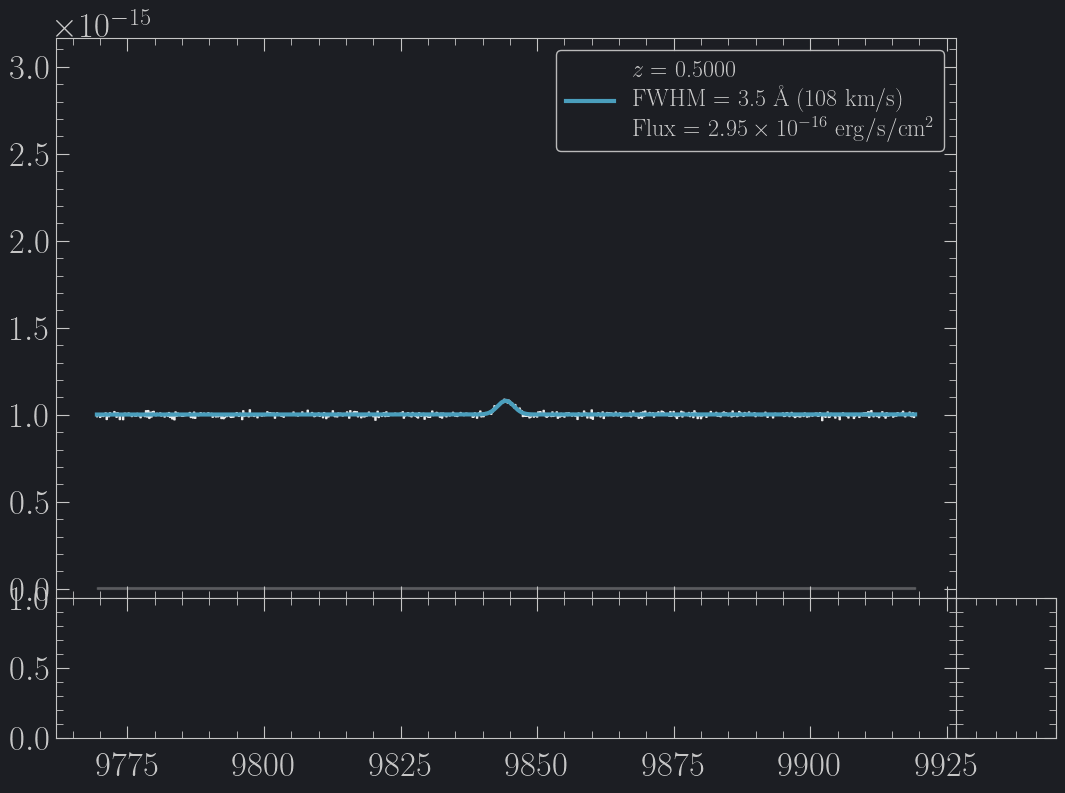

In [5]:
wave = np.arange(5000, 10000, 0.2) * u.AA
SNR = 100
flux = (default_rng().standard_normal(len(wave)) + SNR) * 1e-17 * ergscm2AA
error = 1e-17 * np.ones(len(flux)) * ergscm2AA

zs = np.arange(0, 1.0, 0.5)
for z in zs:
    lam0 = 6562.8*(1+z)*u.AA
    flux_i = flux + gaussian_fct(x=wave, mean=lam0, stddev=1.0*(1+z)*u.AA, amplitude=8e-17*ergscm2AA)


    Ha = EmissionLine('H_alpha', z_guess=z)

    Ha.extract_line_region(
        spectrum=Spectrum1D(
            spectral_axis=wave,
            flux=flux_i,
            uncertainty=StdDevUncertainty(error)
        ),
    )
    
    Ha.fit_continuum(
        regions=[
            (Ha.spectrum['wvlg'].min(),Ha.spectrum['wvlg'].max()),
        ],
        model=models.Linear1D()
    )
    Ha.fit_single_gaussian()
    Ha.measure_flux()
    Ha.show_fit(spec_plot_kw={'color':'C12'}, show_legend=True)



    plt.show()

In [201]:
from astropalmerio.io.fits import read_fits_1D_spectrum
import pandas as pd
fname = Path('/Users/palmerio/Science_projects/Papers/GRB221009A/data/GRB221009A_VIS_tell_fluxcorr.txt')
# wave, flux, error = read_fits_1D_spectrum(fname)
df = pd.read_csv(
            fname,
            sep='\s+',
            names=[
                'wvlg',
                'flux',
                'error',
                'flux_corr',
                'flux_norm',
                'telluric_corr',
            ]
        )
wave = 10*df['wvlg'].to_numpy()
if all(df['flux_corr'].isna()):
    flux = df['flux'].to_numpy()
    error = df['error'].to_numpy()
else:
    df['error_corr'] = df['error'] * df['flux_corr']/df['flux']
    flux = df['flux_corr'].to_numpy()
    error = df['error_corr'].to_numpy()

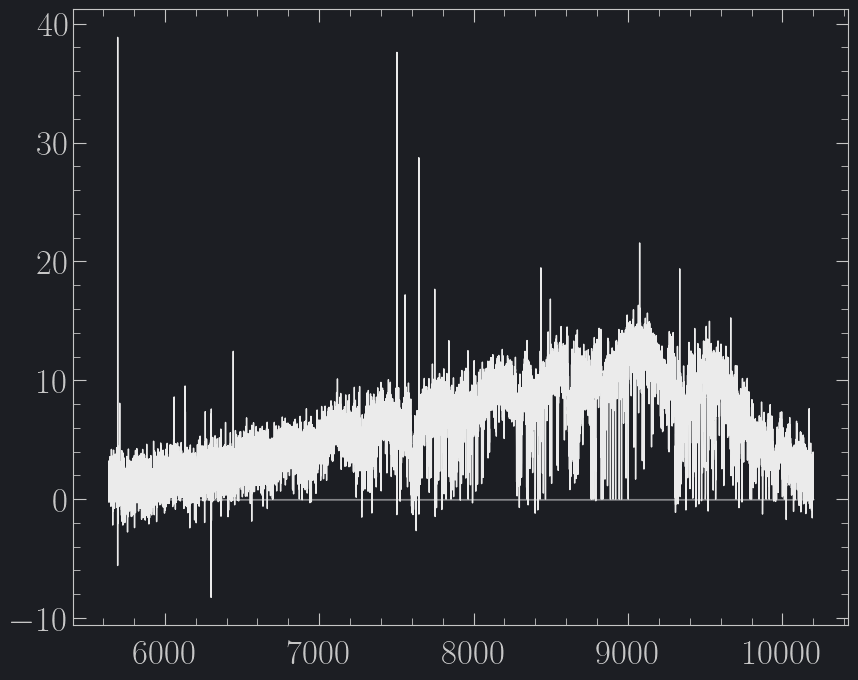

In [203]:
SNR = 10
continuum = 1e-17

# wave = np.arange(6520, 6630, 0.2) *u.AA

# flux = (default_rng().standard_normal(len(wave)) + SNR) * continuum * ergscm2AA
# error = continuum * np.ones(len(flux)) * ergscm2AA

# lines = ['H_alpha', 'NII_6584']
# lams = []
# for l in lines:
#     EL = EmissionLine(l)
#     lam0 = EL.properties['rest_awav']
#     lams.append(lam0)
#     flux = flux + gaussian_fct(x=wave, mean=lam0, stddev=2.0*u.AA, amplitude=8e-17*ergscm2AA)

# flux = flux.value
# wave = wave.value

flux_norm = flux/error
fig, ax = plt.subplots()
ax.plot(wave, flux_norm, lw=1, c='C12')
# ax.fill_between(wave.value, error.value, alpha=0.5,  color='C12')
ax.fill_between(wave, error, alpha=0.5,  color='C12')

plt.show()

In [204]:
from scipy.signal import find_peaks_cwt, find_peaks


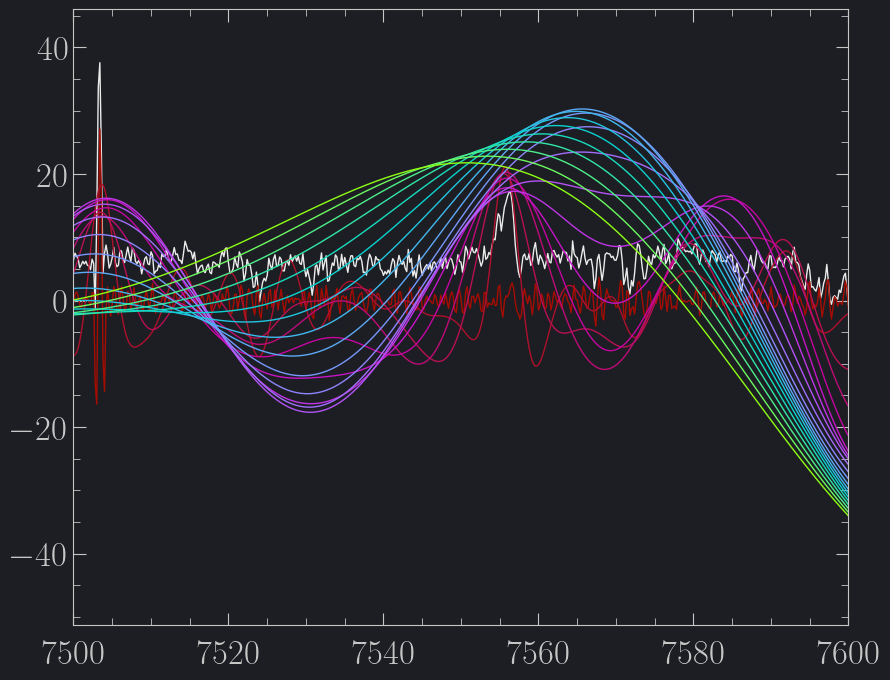

In [216]:
from scipy.signal import convolve, cwt, ricker


width = 10*u.AA
dlam = wave[1]-wave[0]
npix = width/dlam

widths = np.arange(1, 200, 10)
flux_convs = cwt(flux_norm, ricker, widths)

fig, ax = plt.subplots()
ax.plot(wave, flux_norm, lw=1, c='C12')

colors = cmr.take_cmap_colors('cmr.neon', len(widths), cmap_range=(0.0, 1), return_fmt='hex')

for i,f in enumerate(flux_convs):
    ax.plot(wave, f, lw=1, color=colors[i])
ax.set_xlim(7500, 7600)

plt.show()

In [229]:
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve, cwt, ricker


width = 10*u.AA
dlam = wave[1]-wave[0]
npix = width/dlam

widths = np.arange(1, 10, 1)
flux_convs = []
for w in widths:
    flux_convs.append(gaussian_filter(flux_norm, w))


575
334
204
171
135
108
82
67
59


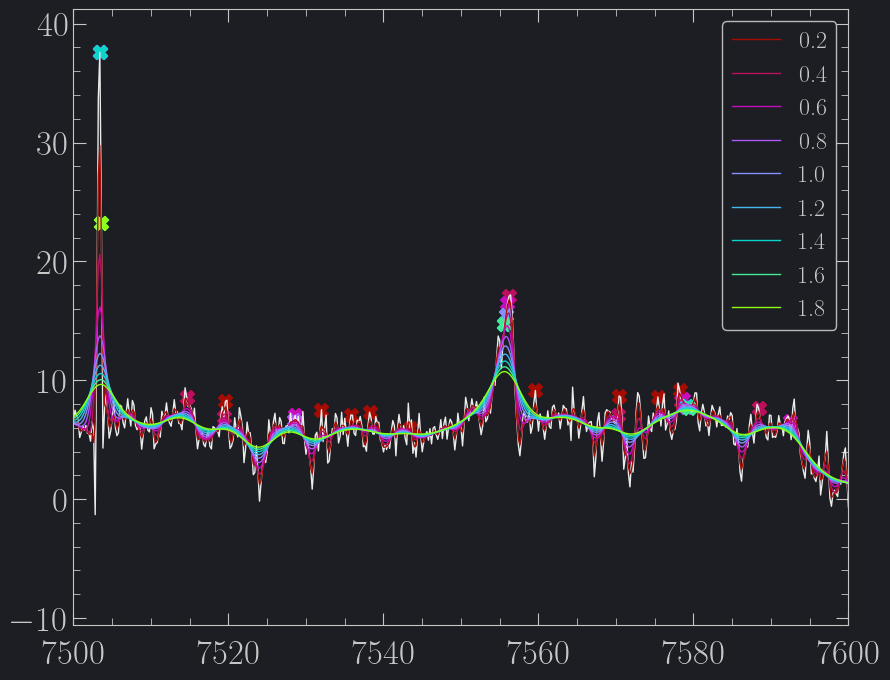

In [243]:
fig, ax = plt.subplots()
ax.plot(wave, flux_norm, lw=1, c='C12')
peaks_arr = np.empty(0)
colors = cmr.take_cmap_colors('cmr.neon', len(widths), cmap_range=(0.0, 1), return_fmt='hex')
for i,f in enumerate(flux_convs):
    ax.plot(wave, f, lw=1, color=colors[i], label=f"{dlam*widths[i]:.1f}")
    peaks, properties = find_peaks(f, prominence=2, width=[5,100])
    print(len(peaks))
    peaks_arr =  np.concatenate((peaks_arr,peaks))
    ax.scatter(wave[peaks], flux_norm[peaks], marker='X', lw=1, color=colors[i])
#     plt.vlines(x=wave[peaks], ymin=flux_norm[peaks] - properties["prominences"],
#            ymax = flux_norm[peaks], color = colors[i])

#     plt.hlines(y=properties["width_heights"], xmin=wave[properties["left_ips"].astype(int)],
#            xmax=wave[properties["right_ips"].astype(int)], color = colors[i])
    
ax.legend()
ax.set_xlim(7500, 7600)
# ax.set_xlim(5700, 5800)
plt.show()

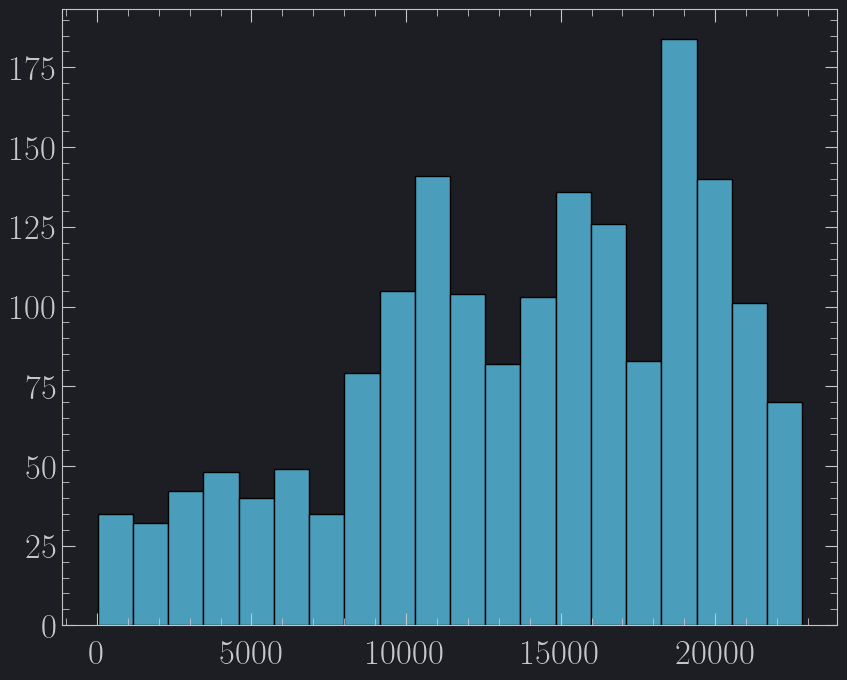

In [247]:

# peaks_hist, _ = np.histogram(peaks_list)


fig, ax = plt.subplots()

ax.hist(peaks_arr, bins=20)

plt.show()

In [222]:
properties

{'prominences': array([3.53741722, 3.18000832]),
 'left_bases': array([18697, 18697]),
 'right_bases': array([19207, 19418]),
 'widths': array([55.06008728, 48.7038205 ]),
 'width_heights': array([7.65912012, 8.47141627]),
 'left_ips': array([19126.42588713, 19344.90485598]),
 'right_ips': array([19181.48597442, 19393.60867648])}